<a href="https://colab.research.google.com/github/hwangdav000/CNN-Transformer/blob/main/CropClassification_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=cxulMJ6boUwHptzWYhcxGHm7oxK79o7pv9AD9eIf1nE&tc=RI5zADkczWwh7aY4wsLYgGW_ie4YQYimi9W6MWUAgJ0&cc=iaybLcuWrHpS8VLbRMQYRkZX-742g8XRRjXV-PBKvd8

The authorization workflow will generate a code, which you should paste in the box below.


KeyboardInterrupt: ignored

In [ ]:
import io
import os
import pandas as pd
import json
import numpy as np
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
S2path = '/content/drive/MyDrive/Colab_Notebooks/ProjectB/Sentinel2/'
L8path = '/content/drive/MyDrive/Colab_Notebooks/ProjectB/Landsat8/'
Prepath = '/content/drive/MyDrive/Colab_Notebooks/ProjectB/Preprocessed_Data/'
Modpath = '/content/drive/MyDrive/Colab_Notebooks/ProjectB/Models/'

In [ ]:
crops = ['Corn', 'Rice', 'Alfalfa', 'Clover_Wildflowers', 'Grapes', 'Almonds', 'Walnuts', 'Grassland_Pasture', 'Cherries', 'Safflower']
S2bands = ['10', '20', '60']
L8bands = ['30']
numDatasets = ['', '2', '3', '4', '5','6','7','8','9','10']

In [ ]:
# parse sentinel 2 data
Dataset = None
t = True
S2_Data = []
for c in range(len(crops)):

  S2_Crop = [[], [], []]
  for r in range(len(S2bands)):
    start =0
    res = S2bands[r]
    crop = crops[c]
    m_int = ((60/int(res))**2)
    y_int = m_int*6

    for d in numDatasets:
      path = S2path + 'S2Bands' +  d + '_' + crop + '_' + res + '.geojson'
      
      with open(path) as f:
          Dataset = json.load(f)
          df = pd.DataFrame(Dataset['features'])

      # get the points from interva
      for p in range(0, 20):
        p_data = [] 

        # get starting point
        start = p*(y_int)

        # store bands 6 bi-monthly 
        for bm in range(0, 6):
          
          # get correct range according to res 
          month = start + bm*(m_int)
          e_month = month + (m_int)

          # store the data in the interval in list of dictionary
          m_data = df['properties'][int(month):int(e_month)]

          # add monthly data to point 
          p_data.append(m_data.reset_index(drop=True))
        
        # append point to crop data with specific resolution
        S2_Crop[r].append(p_data)
  # append crop data
  S2_Data.append(S2_Crop)

In [ ]:
# parse Landsat8 data
Dataset = None
L8_Data = []
for c in range(len(crops)):

  L8_Crop = [[]]
  for r in range(len(L8bands)):
    start =0
    res = L8bands[r]
    crop = crops[c]
    m_int = ((60/int(res))**2)
    y_int = m_int*6

    for d in numDatasets:
      path = L8path + 'L8Bands' +  d + '_' + crop + '_' + res + '.geojson'
      
      with open(path) as f:
          Dataset = json.load(f)
          df = pd.DataFrame(Dataset['features'])

      # get the points from interval
      for p in range(0, 20):
        p_data = [] 

        # get starting point
        start = p*(y_int)

        # store bands 6 bi-monthly 
        for bm in range(0, 6):
          
          # get correct range according to res 
          month = start + bm*(m_int)
          e_month = month + (m_int)

          # store the data in the interval in list of dictionary
          m_data = df['properties'][int(month):int(e_month)]
          
          # add monthly data to point 
          p_data.append(m_data.reset_index(drop=True))
        
        # append point to crop data with specific resolution
        L8_Crop[r].append(p_data)
  # append crop data
  L8_Data.append(L8_Crop)

In [ ]:
#Combine S2 and L8 Data
Data = S2_Data.copy()
Data2 = L8_Data.copy()
for i in range(0, 10):
  Data[i].insert(2, Data2[i][0])

In [ ]:
#Swap bands and datapoints
Data_s = [[[[] for _ in range(4)] for _ in range(200)] for _ in range(10)]

for i in range(0,10):
  for k in range(0,4):
    for j in range(0,200):
      Data_s[i][j][k] = Data[i][k][j]

In [ ]:
#Rename to data
Data = Data_s.copy()

In [ ]:
#Turn data into np arrays
Data=np.array([np.array([np.array(x2) for x2 in x1]) for x1 in Data])

<ipython-input-216-55f95fb9f389>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data=np.array([np.array([np.array(x2) for x2 in x1]) for x1 in Data])


In [ ]:
#Swap resolution and bi-monthly
Data_s = [[[[[] for _ in range(4)] for _ in range(6)] for _ in range(200)] for _ in range(10)]

for i in range(0,10):
  for j in range(0,200):
    for k in range(0,4):
      for l in range(0,6):
        Data_s[i][j][l][k] = Data[i][j][k][l]

In [ ]:
#Rename
Data = Data_s.copy()

In [ ]:
# Need to iterate through Data and then create 2d array for each month
# Need to make dictionary -> np array of bands, can do this because we concat at end
#crops
for i in range(10):
  # points
  for j in range(200):
    # bi months
    for k in range(6):
      # resolutions
      for l in range(4):
        # turn dict into np array
        dl = Data[i][j][k][l]

        ltemp = []
        for m in range(len(dl)):
          area = dl[m]
          keys = area.keys()
          
          for key in keys:
            if (("B" in key) or ("SR" in key)):
              value = area[key]

              if value < 0:
                value = 0.0

              # forgot to normalize values in S2 
              if ("SR" not in key):
                value *= 0.0001
                  
              # append band
              ltemp.append(value)
        
        # reshape 1d to 3d 
        if (len(dl) == 36):
          # 10 res
          Data[i][j][k][l] = np.reshape(np.array(ltemp).astype(np.float32), (6, 6, 4))

        if (len(dl) == 9):
          # 20 res
          Data[i][j][k][l] = np.reshape(np.array(ltemp).astype(np.float32), (3, 3, 6))

        if (len(dl) == 4):
          # 30 res
          Data[i][j][k][l] = np.reshape(np.array(ltemp).astype(np.float32), (2, 2, 7))

        if (len(dl) == 1):
          # 60 res
          Data[i][j][k][l] = np.reshape(np.array(ltemp).astype(np.float32), (1, 1, 2))
      Data[i][j][k] = np.array(Data[i][j][k])

<ipython-input-219-ff9760b7b494>:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Data[i][j][k] = np.array(Data[i][j][k])


In [ ]:
#Create dataset from data
df = pd.DataFrame(columns = ['1', '2', '3','4','5','6','crop'])

In [ ]:
# Initialize Data for training / testing
M1_10_X = []
M1_20_X = []
M1_30_X = []
M1_60_X = []

M2_10_X = []
M2_20_X = []
M2_30_X = []
M2_60_X = []

M3_10_X = []
M3_20_X = []
M3_30_X = []
M3_60_X = []

M4_10_X = []
M4_30_X = []
M4_20_X = []
M4_60_X = []

M5_10_X = []
M5_20_X = []
M5_30_X = []
M5_60_X = []

M6_10_X = []
M6_20_X = []
M6_30_X = []
M6_60_X = []

Crop = []
Data_fl = []

In [ ]:
# append rows to data
dlist = []
for i in range(10):
  # points
  for j in range(200):
    # Crop
    Crop.append(i)

    # 24 inputs need to test
    M1_10_X.append(Data[i][j][0][0])
    M1_20_X.append(Data[i][j][0][1])
    M1_30_X.append(Data[i][j][0][2])
    M1_60_X.append(Data[i][j][0][3])

    M2_10_X.append(Data[i][j][1][0])
    M2_20_X.append(Data[i][j][1][1])
    M2_30_X.append(Data[i][j][1][2])
    M2_60_X.append(Data[i][j][1][3])

    M3_10_X.append(Data[i][j][2][0])
    M3_20_X.append(Data[i][j][2][1])
    M3_30_X.append(Data[i][j][2][2])
    M3_60_X.append(Data[i][j][2][3])

    M4_10_X.append(Data[i][j][3][0])
    M4_20_X.append(Data[i][j][3][1])
    M4_30_X.append(Data[i][j][3][2])
    M4_60_X.append(Data[i][j][3][3])

    M5_10_X.append(Data[i][j][4][0])
    M5_20_X.append(Data[i][j][4][1])
    M5_30_X.append(Data[i][j][4][2])
    M5_60_X.append(Data[i][j][4][3])

    M6_10_X.append(Data[i][j][5][0])
    M6_20_X.append(Data[i][j][5][1])
    M6_30_X.append(Data[i][j][5][2])
    M6_60_X.append(Data[i][j][5][3])

    Data_fl.append(np.concatenate((
        Data[i][j][0][0].flatten(),
        Data[i][j][0][1].flatten(),
        Data[i][j][0][2].flatten(),
        Data[i][j][0][3].flatten(),

        Data[i][j][1][0].flatten(),
        Data[i][j][1][1].flatten(),
        Data[i][j][1][2].flatten(),
        Data[i][j][1][3].flatten(),

        Data[i][j][2][0].flatten(),
        Data[i][j][2][1].flatten(),
        Data[i][j][2][2].flatten(),
        Data[i][j][2][3].flatten(),

        Data[i][j][3][0].flatten(),
        Data[i][j][3][1].flatten(),
        Data[i][j][3][2].flatten(),
        Data[i][j][3][3].flatten(),

        Data[i][j][4][0].flatten(),
        Data[i][j][4][1].flatten(),
        Data[i][j][4][2].flatten(),
        Data[i][j][4][3].flatten(),

        Data[i][j][5][0].flatten(),
        Data[i][j][5][1].flatten(),
        Data[i][j][5][2].flatten(),
        Data[i][j][5][3].flatten()
        ), axis=0))

Crop = np.array(Crop)
M1_10_X = np.array(M1_10_X)
M1_20_X = np.array(M1_20_X)
M1_30_X = np.array(M1_30_X)
M1_60_X = np.array(M1_60_X)

M2_10_X = np.array(M1_10_X)
M2_20_X = np.array(M1_20_X)
M2_30_X = np.array(M1_30_X)
M2_60_X = np.array(M1_60_X)

M3_10_X = np.array(M1_10_X)
M3_20_X = np.array(M1_20_X)
M3_30_X = np.array(M1_30_X)
M3_60_X = np.array(M1_60_X)

M4_10_X = np.array(M1_10_X)
M4_20_X = np.array(M1_20_X)
M4_30_X = np.array(M1_30_X)
M4_60_X = np.array(M1_60_X)

M5_10_X = np.array(M1_10_X)
M5_20_X = np.array(M1_20_X)
M5_30_X = np.array(M1_30_X)
M5_60_X = np.array(M1_60_X)

M6_10_X = np.array(M1_10_X)
M6_20_X = np.array(M1_20_X)
M6_30_X = np.array(M1_30_X)
M6_60_X = np.array(M1_60_X)

In [ ]:
M6_60_X.shape

(2000, 1, 1, 2)

In [ ]:
# Save Preprocessed Data
from numpy import asarray
from numpy import savez

np.savez(os.path.join(Prepath, 'proc_data.npz'), M1_10_X, M1_20_X, M1_30_X, 
         M1_60_X, M2_10_X, M2_20_X, M2_30_X, M2_60_X, M3_10_X, M3_20_X, 
         M3_30_X, M3_60_X, M4_10_X, M4_20_X, M4_30_X, M4_60_X, M5_10_X, 
         M5_20_X, M5_30_X, M5_60_X, M6_10_X, M6_20_X, M6_30_X, M6_60_X,
         Crop, Data_fl)

In [ ]:
# For using load
import numpy as np
import io
import os
import pandas as pd
import json
import numpy as np
from google.colab import drive
drive.mount('/content/drive/')

Prepath = '/content/drive/MyDrive/Colab_Notebooks/ProjectB/Preprocessed_Data/'
Modpath = '/content/drive/MyDrive/Colab_Notebooks/ProjectB/Models/'

Mounted at /content/drive/


In [ ]:
# load npz file
npzfile = np.load(os.path.join(Prepath, 'proc_data.npz'))

# initialize var from npz file
M1_10_X = npzfile['arr_0']
M1_20_X = npzfile['arr_1']
M1_30_X = npzfile['arr_2']
M1_60_X = npzfile['arr_3']
M2_10_X = npzfile['arr_4']
M2_20_X = npzfile['arr_5']
M2_30_X = npzfile['arr_6']
M2_60_X = npzfile['arr_7']
M3_10_X = npzfile['arr_8']
M3_20_X = npzfile['arr_9']
M3_30_X = npzfile['arr_10']
M3_60_X = npzfile['arr_11']
M4_10_X = npzfile['arr_12']
M4_20_X = npzfile['arr_13']
M4_30_X = npzfile['arr_14']
M4_60_X = npzfile['arr_15']
M5_10_X = npzfile['arr_16']
M5_20_X = npzfile['arr_17']
M5_30_X = npzfile['arr_18']
M5_60_X = npzfile['arr_19']
M6_10_X = npzfile['arr_20']
M6_20_X = npzfile['arr_21']
M6_30_X = npzfile['arr_22']
M6_60_X = npzfile['arr_23']
Crop = npzfile['arr_24']
Data_fl = npzfile['arr_25']

In [ ]:
# split between train / test
# will do 50/150 , 75/125 splits
split = 50
end = 200

M1_10_train_X = M1_10_X[0:split ,:] 
M1_20_train_X = M1_20_X[0:split ,:]  
M1_30_train_X = M1_30_X[0:split ,:]  
M1_60_train_X = M1_60_X[0:split ,:] 

M2_10_train_X = M2_10_X[0:split ,:]  
M2_20_train_X = M2_20_X[0:split ,:]  
M2_30_train_X = M2_30_X[0:split ,:]  
M2_60_train_X = M2_60_X[0:split ,:]

M3_10_train_X = M3_10_X[0:split ,:]  
M3_20_train_X = M3_20_X[0:split ,:]  
M3_30_train_X = M3_30_X[0:split ,:]  
M3_60_train_X = M3_60_X[0:split ,:] 

M4_10_train_X = M4_10_X[0:split ,:]  
M4_20_train_X = M4_20_X[0:split ,:]  
M4_30_train_X = M4_30_X[0:split ,:]  
M4_60_train_X = M4_60_X[0:split ,:] 

M5_10_train_X = M5_10_X[0:split ,:]  
M5_20_train_X = M5_20_X[0:split ,:]  
M5_30_train_X = M5_30_X[0:split ,:]  
M5_60_train_X = M5_60_X[0:split ,:] 

M6_10_train_X = M6_10_X[0:split ,:]  
M6_20_train_X = M6_20_X[0:split ,:]  
M6_30_train_X = M6_30_X[0:split ,:]  
M6_60_train_X = M6_60_X[0:split ,:] 

M1_10_test_X = M1_10_X[split:end, :]  
M1_20_test_X = M1_20_X[split:end, :]  
M1_30_test_X = M1_30_X[split:end, :]  
M1_60_test_X = M1_60_X[split:end, :]  

M2_10_test_X = M2_10_X[split:end, :]  
M2_20_test_X = M2_20_X[split:end, :]  
M2_30_test_X = M2_30_X[split:end, :]  
M2_60_test_X = M2_60_X[split:end, :]  

M3_10_test_X = M3_10_X[split:end, :]  
M3_20_test_X = M3_20_X[split:end, :]  
M3_30_test_X = M3_30_X[split:end, :]  
M3_60_test_X = M3_60_X[split:end, :]  

M4_10_test_X = M4_10_X[split:end, :]  
M4_20_test_X = M4_20_X[split:end, :]  
M4_30_test_X = M4_30_X[split:end, :]  
M4_60_test_X = M4_60_X[split:end, :]  

M5_10_test_X = M5_10_X[split:end, :]  
M5_20_test_X = M5_20_X[split:end, :]  
M5_30_test_X = M5_30_X[split:end, :]  
M5_60_test_X = M5_60_X[split:end, :]  

M6_10_test_X = M6_10_X[split:end, :]  
M6_20_test_X = M6_20_X[split:end, :]  
M6_30_test_X = M6_30_X[split:end, :]  
M6_60_test_X = M6_60_X[split:end, :]

Datafl_train_X = Data_fl[0:split]
Datafl_test_X = Data_fl[split:end]

Crop_train_y = Crop[0:split]
Crop_test_y = Crop[split:end]

In [ ]:
ival = 200
# Each crop has 200 points
# Use 50 points for training
# use 50 points for testing
for n, idx in enumerate(range(200, 2000, 200), 2):
  # need to make sure to split evenly across crops
  M1_10_train_X = np.concatenate((M1_10_train_X, M1_10_X[idx:idx+split, :]), axis=0) 
  M1_20_train_X = np.concatenate((M1_20_train_X, M1_20_X[idx:idx+split, :]), axis=0)  
  M1_30_train_X = np.concatenate((M1_30_train_X, M1_30_X[idx:idx+split, :]), axis=0)  
  M1_60_train_X = np.concatenate((M1_60_train_X, M1_60_X[idx:idx+split, :]), axis=0) 

  M2_10_train_X = np.concatenate((M2_10_train_X, M2_10_X[idx:idx+split, :]), axis=0)  
  M2_20_train_X = np.concatenate((M2_20_train_X, M2_20_X[idx:idx+split, :]), axis=0)  
  M2_30_train_X = np.concatenate((M2_30_train_X, M2_30_X[idx:idx+split, :]), axis=0)  
  M2_60_train_X = np.concatenate((M2_60_train_X, M2_60_X[idx:idx+split, :]), axis=0)

  M3_10_train_X = np.concatenate((M3_10_train_X, M3_10_X[idx:idx+split, :]), axis=0)  
  M3_20_train_X = np.concatenate((M3_20_train_X, M3_20_X[idx:idx+split, :]), axis=0)  
  M3_30_train_X = np.concatenate((M3_30_train_X, M3_30_X[idx:idx+split, :]), axis=0)  
  M3_60_train_X = np.concatenate((M3_60_train_X, M3_60_X[idx:idx+split, :]), axis=0) 

  M4_10_train_X = np.concatenate((M4_10_train_X, M4_10_X[idx:idx+split, :]), axis=0)  
  M4_20_train_X = np.concatenate((M4_20_train_X, M4_20_X[idx:idx+split, :]), axis=0)  
  M4_30_train_X = np.concatenate((M4_30_train_X, M4_30_X[idx:idx+split, :]), axis=0)  
  M4_60_train_X = np.concatenate((M4_60_train_X, M4_60_X[idx:idx+split, :]), axis=0) 

  M5_10_train_X = np.concatenate((M5_10_train_X, M5_10_X[idx:idx+split, :]), axis=0)  
  M5_20_train_X = np.concatenate((M5_20_train_X, M5_20_X[idx:idx+split, :]), axis=0)  
  M5_30_train_X = np.concatenate((M5_30_train_X, M5_30_X[idx:idx+split, :]), axis=0)  
  M5_60_train_X = np.concatenate((M5_60_train_X, M5_60_X[idx:idx+split, :]), axis=0) 

  M6_10_train_X = np.concatenate((M6_10_train_X, M6_10_X[idx:idx+split, :]), axis=0)  
  M6_20_train_X = np.concatenate((M6_20_train_X, M6_20_X[idx:idx+split, :]), axis=0)  
  M6_30_train_X = np.concatenate((M6_30_train_X, M6_30_X[idx:idx+split, :]), axis=0)  
  M6_60_train_X = np.concatenate((M6_60_train_X, M6_60_X[idx:idx+split, :]), axis=0) 

  M1_10_test_X = np.concatenate((M1_10_test_X, M1_10_X[idx+split:n*ival, :]), axis=0)  
  M1_20_test_X = np.concatenate((M1_20_test_X, M1_20_X[idx+split:n*ival, :]), axis=0)  
  M1_30_test_X = np.concatenate((M1_30_test_X, M1_30_X[idx+split:n*ival, :]), axis=0)  
  M1_60_test_X = np.concatenate((M1_60_test_X, M1_60_X[idx+split:n*ival, :]), axis=0)  

  M2_10_test_X = np.concatenate((M2_10_test_X, M2_10_X[idx+split:n*ival, :]), axis=0)  
  M2_20_test_X = np.concatenate((M2_20_test_X, M2_20_X[idx+split:n*ival, :]), axis=0)  
  M2_30_test_X = np.concatenate((M2_30_test_X, M2_30_X[idx+split:n*ival, :]), axis=0)  
  M2_60_test_X = np.concatenate((M2_60_test_X, M2_60_X[idx+split:n*ival, :]), axis=0)  

  M3_10_test_X = np.concatenate((M3_10_test_X, M3_10_X[idx+split:n*ival, :]), axis=0)  
  M3_20_test_X = np.concatenate((M3_20_test_X, M3_20_X[idx+split:n*ival, :]), axis=0)  
  M3_30_test_X = np.concatenate((M3_30_test_X, M3_30_X[idx+split:n*ival, :]), axis=0)  
  M3_60_test_X = np.concatenate((M3_60_test_X, M3_60_X[idx+split:n*ival, :]), axis=0)  

  M4_10_test_X = np.concatenate((M4_10_test_X, M4_10_X[idx+split:n*ival, :]), axis=0)  
  M4_20_test_X = np.concatenate((M4_20_test_X, M4_20_X[idx+split:n*ival, :]), axis=0)  
  M4_30_test_X = np.concatenate((M4_30_test_X, M4_30_X[idx+split:n*ival, :]), axis=0)  
  M4_60_test_X = np.concatenate((M4_60_test_X, M4_60_X[idx+split:n*ival, :]), axis=0)  

  M5_10_test_X = np.concatenate((M5_10_test_X, M5_10_X[idx+split:n*ival, :]), axis=0)  
  M5_20_test_X = np.concatenate((M5_20_test_X, M5_20_X[idx+split:n*ival, :]), axis=0)  
  M5_30_test_X = np.concatenate((M5_30_test_X, M5_30_X[idx+split:n*ival, :]), axis=0)  
  M5_60_test_X = np.concatenate((M5_60_test_X, M5_60_X[idx+split:n*ival, :]), axis=0)  

  M6_10_test_X = np.concatenate((M6_10_test_X, M6_10_X[idx+split:n*ival, :]), axis=0)  
  M6_20_test_X = np.concatenate((M6_20_test_X, M6_20_X[idx+split:n*ival, :]), axis=0)  
  M6_30_test_X = np.concatenate((M6_30_test_X, M6_30_X[idx+split:n*ival, :]), axis=0)  
  M6_60_test_X = np.concatenate((M6_60_test_X, M6_60_X[idx+split:n*ival, :]), axis=0)

  Datafl_train_X = np.concatenate((Datafl_train_X, Data_fl[idx:idx+split]), axis=0)
  Datafl_test_X = np.concatenate((Datafl_test_X, Data_fl[idx+split:n*ival]), axis=0)
    
  Crop_train_y = np.concatenate((Crop_train_y, Crop[idx:idx+split]), axis=0)
  Crop_test_y = np.concatenate((Crop_test_y, Crop[idx+split:n*ival]), axis=0)


In [ ]:
#Shuffle values to make sure that values are randomized
# shuffle train values
from sklearn.utils import shuffle
M1_10_train_X,   M1_20_train_X,  M1_30_train_X,   M1_60_train_X, \
M2_10_train_X,   M2_20_train_X,  M2_30_train_X,   M2_60_train_X, \
M3_10_train_X,   M3_20_train_X,  M3_30_train_X,   M3_60_train_X, \
M4_10_train_X,   M4_20_train_X,  M4_30_train_X,   M4_60_train_X, \
M5_10_train_X,   M5_20_train_X,  M5_30_train_X,   M5_60_train_X, \
M6_10_train_X,   M6_20_train_X,  M6_30_train_X,   M6_60_train_X, \
Datafl_train_X,  Crop_train_y= \
shuffle( 
  M1_10_train_X,   M1_20_train_X,  M1_30_train_X,   M1_60_train_X, 
  M2_10_train_X,   M2_20_train_X,  M2_30_train_X,   M2_60_train_X, 
  M3_10_train_X,   M3_20_train_X,  M3_30_train_X,   M3_60_train_X, 
  M4_10_train_X,   M4_20_train_X,  M4_30_train_X,   M4_60_train_X, 
  M5_10_train_X,   M5_20_train_X,  M5_30_train_X,   M5_60_train_X, 
  M6_10_train_X,   M6_20_train_X,  M6_30_train_X,   M6_60_train_X, 
  Datafl_train_X,  Crop_train_y, random_state=0)

In [ ]:
# Shuffle test values
M1_10_test_X,   M1_20_test_X,  M1_30_test_X,   M1_60_test_X, \
M2_10_test_X,   M2_20_test_X,  M2_30_test_X,   M2_60_test_X, \
M3_10_test_X,   M3_20_test_X,  M3_30_test_X,   M3_60_test_X, \
M4_10_test_X,   M4_20_test_X,  M4_30_test_X,   M4_60_test_X, \
M5_10_test_X,   M5_20_test_X,  M5_30_test_X,   M5_60_test_X, \
M6_10_test_X,   M6_20_test_X,  M6_30_test_X,   M6_60_test_X, \
Datafl_test_X,  Crop_test_y  = \
shuffle( 
  M1_10_test_X,   M1_20_test_X,  M1_30_test_X,   M1_60_test_X, 
  M2_10_test_X,   M2_20_test_X,  M2_30_test_X,   M2_60_test_X, 
  M3_10_test_X,   M3_20_test_X,  M3_30_test_X,   M3_60_test_X, 
  M4_10_test_X,   M4_20_test_X,  M4_30_test_X,   M4_60_test_X, 
  M5_10_test_X,   M5_20_test_X,  M5_30_test_X,   M5_60_test_X, 
  M6_10_test_X,   M6_20_test_X,  M6_30_test_X,   M6_60_test_X, 
  Datafl_test_X,  Crop_test_y, random_state=0)

In [ ]:
#!pip install keras-nlp --upgrade

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import Concatenate
from keras.layers import Flatten
from keras.layers import Softmax
from keras.layers import Add
from keras.layers import Reshape
from keras.layers import Softmax
from keras.layers import Dense
from keras.layers import BatchNormalization
#import keras_nlp
#from keras_nlp.layers import TransformerEncoder

from keras.utils import plot_model
# Create the input layer for the resolution
# assume that we are directly receiving the resolutions 

# 1. Create the input
M1_10 = Input(shape=(6,6,4))
M1_20 = Input(shape=(3,3,6))
M1_30 = Input(shape=(2,2,7))
M1_60 = Input(shape=(1,1,2))

M2_10 = Input(shape=(6,6,4))
M2_20 = Input(shape=(3,3,6))
M2_30 = Input(shape=(2,2,7))
M2_60 = Input(shape=(1,1,2))

M3_10 = Input(shape=(6,6,4))
M3_20 = Input(shape=(3,3,6))
M3_30 = Input(shape=(2,2,7))
M3_60 = Input(shape=(1,1,2))

M4_10 = Input(shape=(6,6,4))
M4_20 = Input(shape=(3,3,6))
M4_30 = Input(shape=(2,2,7))
M4_60 = Input(shape=(1,1,2))

M5_10 = Input(shape=(6,6,4))
M5_20 = Input(shape=(3,3,6))
M5_30 = Input(shape=(2,2,7))
M5_60 = Input(shape=(1,1,2))

M6_10 = Input(shape=(6,6,4))
M6_20 = Input(shape=(3,3,6))
M6_30 = Input(shape=(2,2,7))
M6_60 = Input(shape=(1,1,2))

In [ ]:
from keras.layers import Concatenate
#2. Spatial Unification (Transpose Convolution)
# question if filter -> band feature conv2d transpose or need to do separately
def spatial_unification(res1, res2, res3, res4):
  # apply batch normalization after each convolution
  # conv2d automatically uses Glorot uniform initializer also called Xaviar Uniform Initializer

  # res10
  b1 = Conv2DTranspose(4, (1, 1), strides=(1, 1), padding='valid', input_shape=(6, 6, 4))(res1)
  b1 = BatchNormalization()(b1)

  # res20
  b2 = Conv2DTranspose(6, (4, 4), strides=(1, 1), padding='valid', input_shape=(3, 3, 6))(res2)
  b2 = BatchNormalization()(b2)

  # res30
  b3 = Conv2DTranspose(7, (5, 5), strides=(1, 1), padding='valid', input_shape=(2, 2, 7))(res3)
  b3 = BatchNormalization()(b3)

  # res60
  b4 = Conv2DTranspose(2, (6, 6), strides=(1, 1), padding='valid', input_shape=(1, 1, 2))(res4)
  b4 = BatchNormalization()(b4)

  return Concatenate(axis=-1)([b1, b2, b3, b4])

In [ ]:
#3. Spectral Unification (Convolution)
def spectral_unification(S_i):
  G_i = Conv2D(5, (1,1), padding='valid', activation='relu')(S_i)
  G_i = BatchNormalization()(G_i)
  return Flatten()(G_i)

In [ ]:
# depth - d_model = 180
# seq_len - bi monthly = 6
# Need to add None to accomodate for Keras format
import numpy as np
def getPositionEncoding(seq_len=6, d=180, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return tf.convert_to_tensor(P.flatten()[None,:])
 
P = getPositionEncoding()
P.shape

TensorShape([1, 1080])

In [ ]:
from tensorflow import keras
from keras import layers
# ff_dim - embed dim
# num_heads = 6 
# head_size - dmodel/h = 180/6 = 30 = 30
# no dropout

def transformer_encoder(inputs, head_size=30, num_heads=6, ff_dim=180, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

# transformer consists of 4 transformer encoder blocks
def transformer(inputs, encoder_blocks=4):
  x = inputs
  for _ in range(encoder_blocks):
    x = transformer_encoder(x)
  return x

In [ ]:
# feed forward + softmax
def ff_pred(inputs):
  x = Flatten()(inputs)
  ff1 = Dense(units=100, activation='relu')(x)
  ff2 = Dense(units=40, activation='relu')(ff1)

  # 10 crops
  ff3 = Dense(units=10, activation='softmax')(ff2)
  return ff3

In [ ]:
# RF-200 (1)
%%time
from sklearn.ensemble import RandomForestClassifier

# creating a RF classifier
rf_clf = RandomForestClassifier(n_estimators = 200)  
  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
rf_clf.fit(Datafl_train_X, Crop_train_y)
  
# performing predictions on the test dataset
rf_clf_pred = rf_clf.predict(Datafl_test_X)

CPU times: user 3.51 s, sys: 14.6 ms, total: 3.53 s
Wall time: 3.53 s


In [ ]:
# metrics are used to find accuracy or error
from sklearn import metrics  
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(Crop_test_y.flatten(), rf_clf_pred))

# using metrics module for cohen Kappa calculation
print("KAPPA SCORE OF THE MODEL: ", metrics.cohen_kappa_score(Crop_test_y.flatten(), rf_clf_pred))

ACCURACY OF THE MODEL:  0.94
KAPPA SCORE OF THE MODEL:  0.9333333333333333


Class Accuracy:  [0.952 0.952 0.976 0.912 0.96  0.944 0.912 0.984 0.888 0.92 ]
Overall Accuracy:  0.94
Average Accuracy:  0.9400000000000001


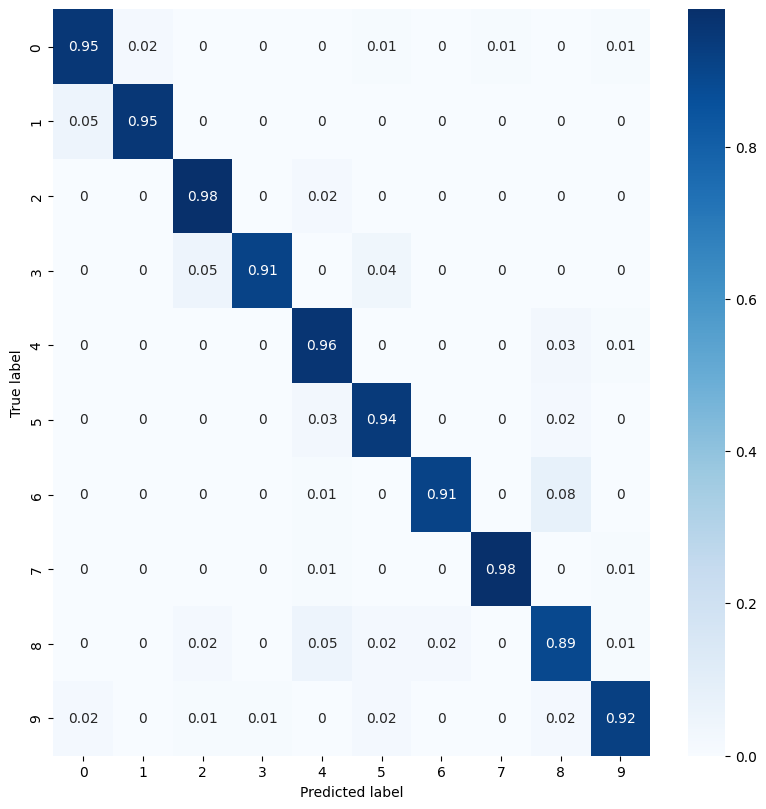

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

y_true = Crop_test_y.flatten()
classes=[0,1,2,3,4,5,6,7,8,9]

con_mat = tf.math.confusion_matrix(labels=y_true, predictions=rf_clf_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_norm2 = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=4)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(8, 8))

# Accuracy
DI = con_mat_norm2.diagonal()
OA = (np.sum(con_mat.diagonal())/len(y_true))
AA = (np.sum(DI)/10)
print("Class Accuracy: ", DI)
print("Overall Accuracy: ", OA)
print("Average Accuracy: ", AA)

# heatmap
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
%%time
# SVM - RBF (2)
from sklearn import svm
from sklearn.model_selection import cross_validate


# creating a SVM-RBF classifier
svm_clf = svm.SVC(kernel='rbf')
  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
results = cross_validate(estimator=svm_clf,
                               X=Datafl_train_X,
                               y=Crop_train_y,
                               cv=5,
                               return_train_score=True,
                               return_estimator=True)

CPU times: user 3.53 s, sys: 12.3 ms, total: 3.54 s
Wall time: 5.29 s


In [ ]:
# select best SVM from cross validation
accuracies = results['test_score'] # what you had before
svms = results['estimator']
svm = svms[np.argmax(accuracies)]
print(accuracies)
svm_clf_pred = svm.predict(Datafl_test_X)

[0.87333333 0.88666667 0.89333333 0.83333333 0.92      ]


In [ ]:
# metrics are used to find accuracy or error
from sklearn import metrics  
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(Crop_test_y.flatten(), svm_clf_pred))

# using metrics module for Kohen Kappa calculation
print("KAPPA SCORE OF THE MODEL: ", metrics.cohen_kappa_score(Crop_test_y.flatten(), svm_clf_pred))

ACCURACY OF THE MODEL:  0.8896
KAPPA SCORE OF THE MODEL:  0.8773333333333333


Class Accuracy:  [0.904 0.976 0.72  0.872 0.92  0.92  0.904 0.992 0.76  0.928]
Overall Accuracy:  0.8896
Average Accuracy:  0.8896000000000001


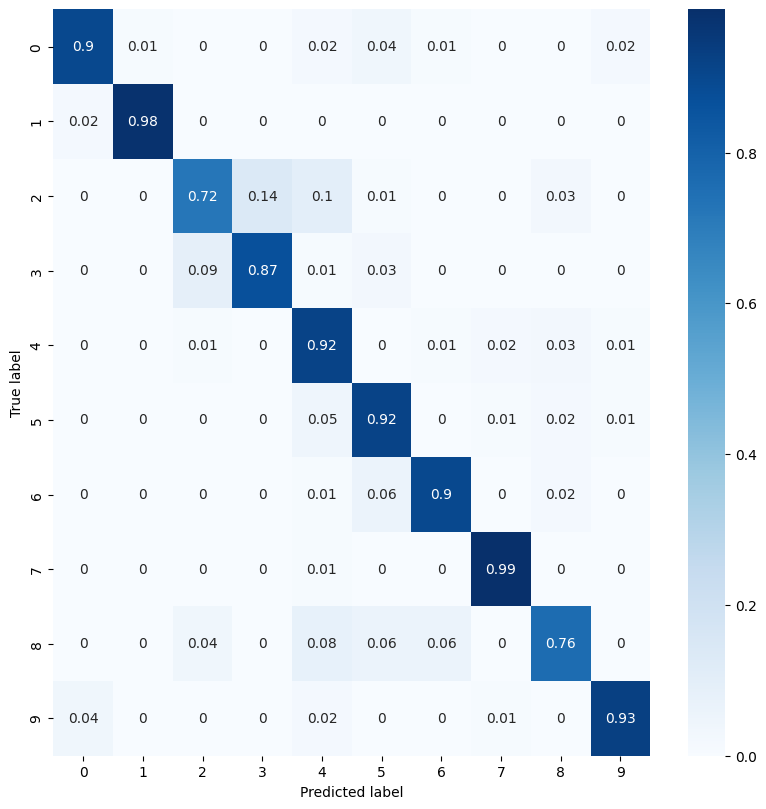

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

y_true = Crop_test_y.flatten()
classes=[0,1,2,3,4,5,6,7,8,9]

con_mat = tf.math.confusion_matrix(labels=y_true, predictions=svm_clf_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_norm2 = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=4)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(8, 8))

# Accuracy
DI = con_mat_norm2.diagonal()
OA = (np.sum(con_mat.diagonal())/len(y_true))
AA = (np.sum(DI)/10)
print("Class Accuracy: ", DI)
print("Overall Accuracy: ", OA)
print("Average Accuracy: ", AA)

# heatmap
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 6, 6, 4)]    0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 3, 3, 6)]    0           []                               
                                                                                                  
 input_27 (InputLayer)          [(None, 2, 2, 7)]    0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, 1, 1, 2)]    0           []                               
                                                                                            

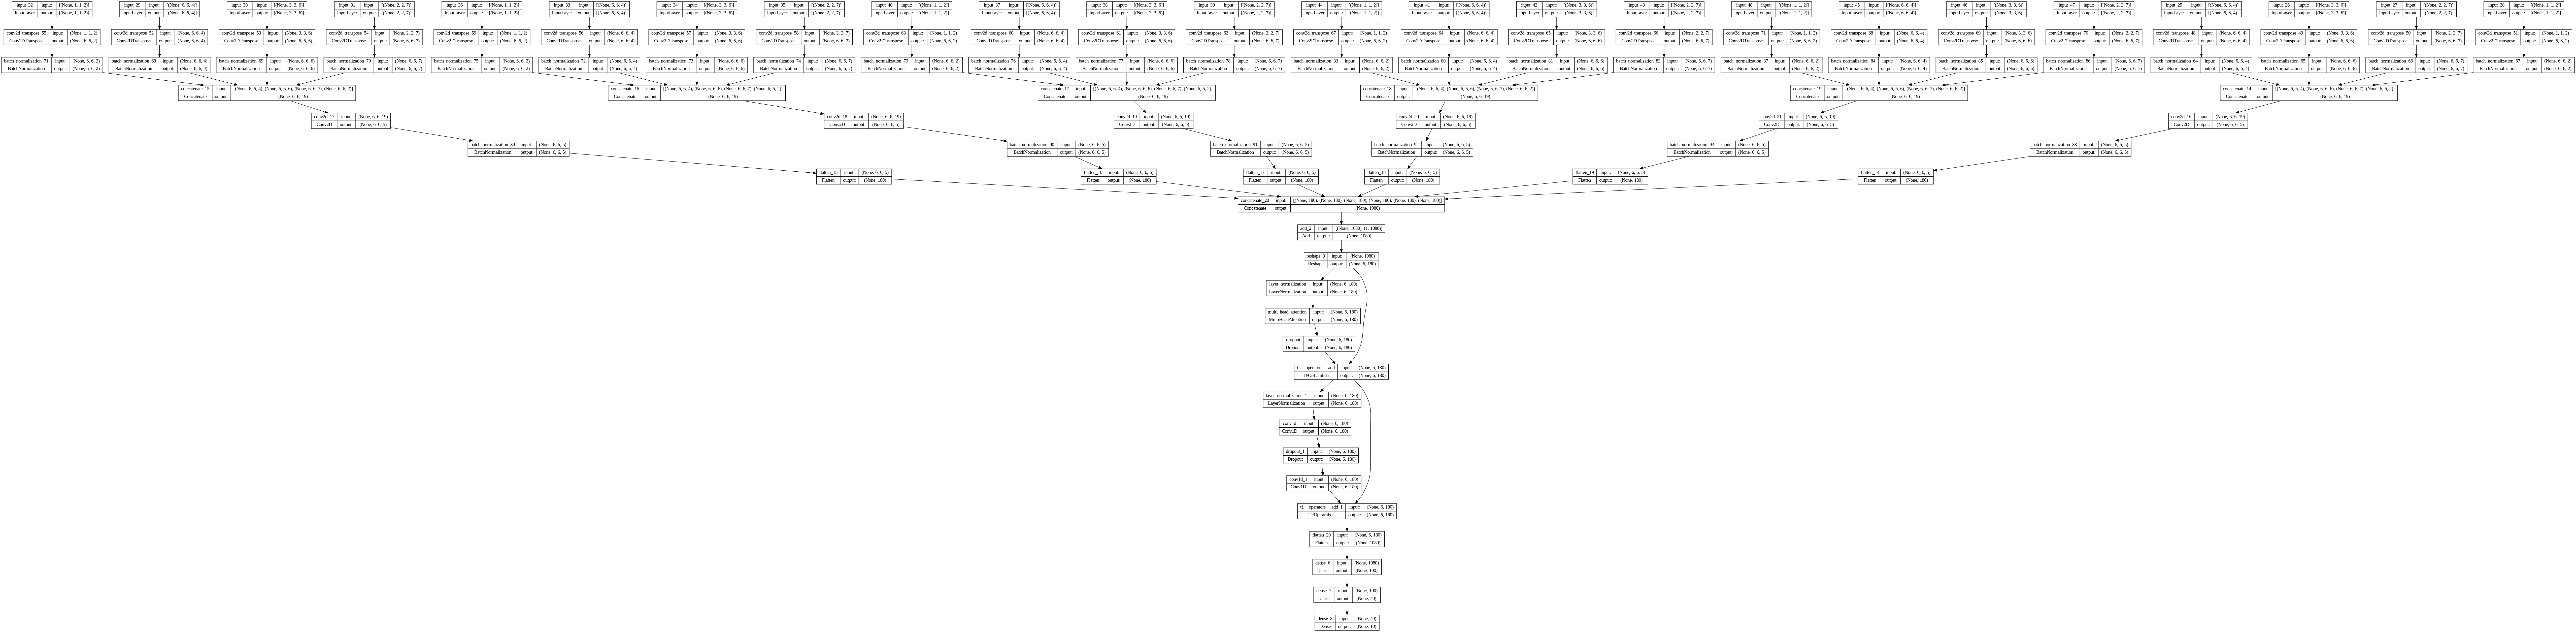

In [ ]:

# CNN-Transformer Layout (3)
# perform spatial unification
S_1 = spatial_unification(M1_10, M1_20, M1_30, M1_60)
S_2 = spatial_unification(M2_10, M2_20, M2_30, M2_60)
S_3 = spatial_unification(M3_10, M3_20, M3_30, M3_60)
S_4 = spatial_unification(M4_10, M4_20, M4_30, M4_60)
S_5 = spatial_unification(M5_10, M5_20, M5_30, M5_60)
S_6 = spatial_unification(M6_10, M6_20, M6_30, M6_60)

# perform spectral unification
E_1 = spectral_unification(S_1)
E_2 = spectral_unification(S_2)
E_3 = spectral_unification(S_3)
E_4 = spectral_unification(S_4)
E_5 = spectral_unification(S_5)
E_6 = spectral_unification(S_6)

# add positional encoding
W_E = Concatenate(axis=-1)([E_1, E_2, E_3, E_4, E_5, E_6])
W_P = getPositionEncoding()

h_0 = Add()([W_E, W_P])
# reshape input to feed into transformer
h_0 = Reshape((6,180))(h_0)

# multilayer transformer encoder uses keras nlp
# encoder = TransformerEncoder(intermediate_dim=180, num_heads=6)

# h_1 = encoder(h_0)
# h_2 = encoder(h_1)
# h_3 = encoder(h_2)
# h_l = encoder(h_3)

h_l = transformer_encoder(h_0)

# feed forward layer + softmax
pred = ff_pred(h_l)

CNN_TF = Model([M1_10, M1_20, M1_30, M1_60, M2_10, M2_20, M2_30, M2_60, M3_10, M3_20, M3_30, M3_60,
              M4_10, M4_20, M4_30, M4_60, M5_10, M5_20, M5_30, M5_60, M6_10, M6_20, M6_30, M6_60],
              [pred])

CNN_TF.summary()
CNN_TF.output_shape
plot_model(CNN_TF, show_shapes=True, to_file='cnn-transformer.png')

In [ ]:
M1_60_train_X.shape

(500, 1, 1, 2)

Epoch 1/1000
30/30 [==============================] - 18s 36ms/step - loss: 2.5283 - accuracy: 0.1240
Epoch 2/1000
30/30 [==============================] - 2s 55ms/step - loss: 2.2587 - accuracy: 0.1720
Epoch 3/1000
30/30 [==============================] - 3s 100ms/step - loss: 2.0592 - accuracy: 0.2587
Epoch 4/1000
30/30 [==============================] - 3s 104ms/step - loss: 1.9369 - accuracy: 0.3520
Epoch 5/1000
30/30 [==============================] - 2s 65ms/step - loss: 1.8466 - accuracy: 0.4227
Epoch 6/1000
30/30 [==============================] - 2s 65ms/step - loss: 1.7696 - accuracy: 0.4627
Epoch 7/1000
30/30 [==============================] - 1s 36ms/step - loss: 1.7059 - accuracy: 0.4960
Epoch 8/1000
30/30 [==============================] - 1s 35ms/step - loss: 1.6569 - accuracy: 0.4933
Epoch 9/1000
30/30 [==============================] - 1s 36ms/step - loss: 1.6163 - accuracy: 0.5053
Epoch 10/1000
30/30 [==============================] - 1s 37ms/step - loss: 1.5728 - acc

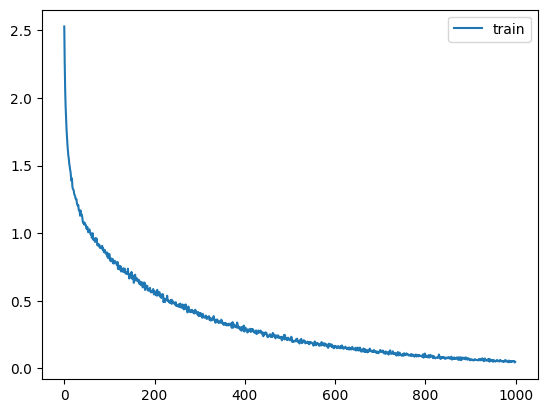

CPU times: user 29min 14s, sys: 49.9 s, total: 30min 4s
Wall time: 23min 56s


In [ ]:
# CNN - Transformer (3)

%%time
from keras import backend as K
from matplotlib import pyplot
        
opt = keras.optimizers.Adadelta(learning_rate=0.01)
CNN_TF.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

history = CNN_TF.fit(
    x=[
      M1_10_train_X,   M1_20_train_X,  M1_30_train_X,   M1_60_train_X,
      M2_10_train_X,   M2_20_train_X,  M2_30_train_X,   M2_60_train_X,
      M3_10_train_X,   M3_20_train_X,  M3_30_train_X,   M3_60_train_X,
      M4_10_train_X,   M4_20_train_X,  M4_30_train_X,   M4_60_train_X,
      M5_10_train_X,   M5_20_train_X,  M5_30_train_X,   M5_60_train_X,
      M6_10_train_X,   M6_20_train_X,  M6_30_train_X,   M6_60_train_X,
       ],
    y=Crop_train_y,
    epochs=1000,
    batch_size=25,
)

pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

# save model
CNN_TF.save(os.path.join(Modpath, 'cnn_tf_s2'))

# 50/150
#20/20 [==============================] - 3s 135ms/step - loss: 0.0120 - accuracy: 1.0000

In [ ]:
# load model
CNN_TF = keras.models.load_model(os.path.join(Modpath, 'cnn_tf_s1'))

In [ ]:
# predictions
CNN_TF_predict_arr = CNN_TF.predict(
      x=[
      M1_10_test_X,   M1_20_test_X,  M1_30_test_X,   M1_60_test_X,
      M2_10_test_X,   M2_20_test_X,  M2_30_test_X,   M2_60_test_X,
      M3_10_test_X,   M3_20_test_X,  M3_30_test_X,   M3_60_test_X,
      M4_10_test_X,   M4_20_test_X,  M4_30_test_X,   M4_60_test_X,
      M5_10_test_X,   M5_20_test_X,  M5_30_test_X,   M5_60_test_X,
      M6_10_test_X,   M6_20_test_X,  M6_30_test_X,   M6_60_test_X,
       ]
  ) 
CNN_TF_predict = np.argmax(CNN_TF_predict_arr, axis=1)

40/40 [==============================] - 3s 21ms/step


In [ ]:
# metrics are used to find accuracy or error
from sklearn import metrics  
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(Crop_test_y.flatten(), CNN_TF_predict))

# using metrics module for cohen Kappa calculation
print("KAPPA SCORE OF THE MODEL: ", metrics.cohen_kappa_score(Crop_test_y.flatten(), CNN_TF_predict))

ACCURACY OF THE MODEL:  0.8264
KAPPA SCORE OF THE MODEL:  0.8071111111111111


Class Accuracy:  [0.768 0.944 0.76  0.904 0.792 0.92  0.632 0.904 0.824 0.816]
Overall Accuracy:  0.8264
Average Accuracy:  0.8264000000000001


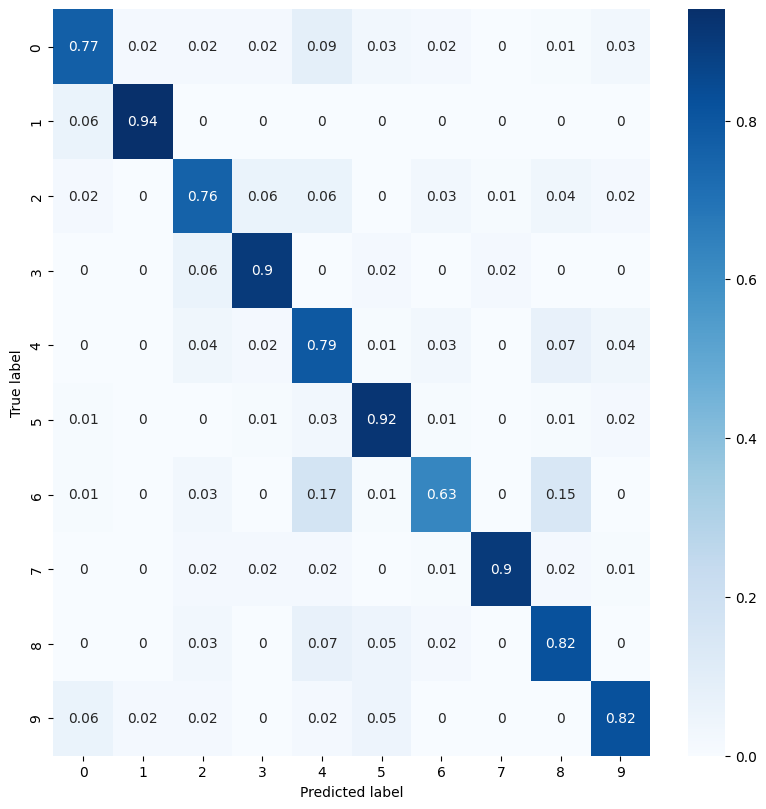

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_true = Crop_test_y.flatten()
classes=[0,1,2,3,4,5,6,7,8,9]

con_mat = tf.math.confusion_matrix(labels=y_true, predictions=CNN_TF_predict).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_norm2 = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=4)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(8, 8))

# Accuracy
DI = con_mat_norm2.diagonal()
OA = (np.sum(con_mat.diagonal())/len(y_true))
AA = (np.sum(DI)/10)
print("Class Accuracy: ", DI)
print("Overall Accuracy: ", OA)
print("Average Accuracy: ", AA)

# heatmap
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 6, 6, 4)]    0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 3, 3, 6)]    0           []                               
                                                                                                  
 input_27 (InputLayer)          [(None, 2, 2, 7)]    0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, 1, 1, 2)]    0           []                               
                                                                                            

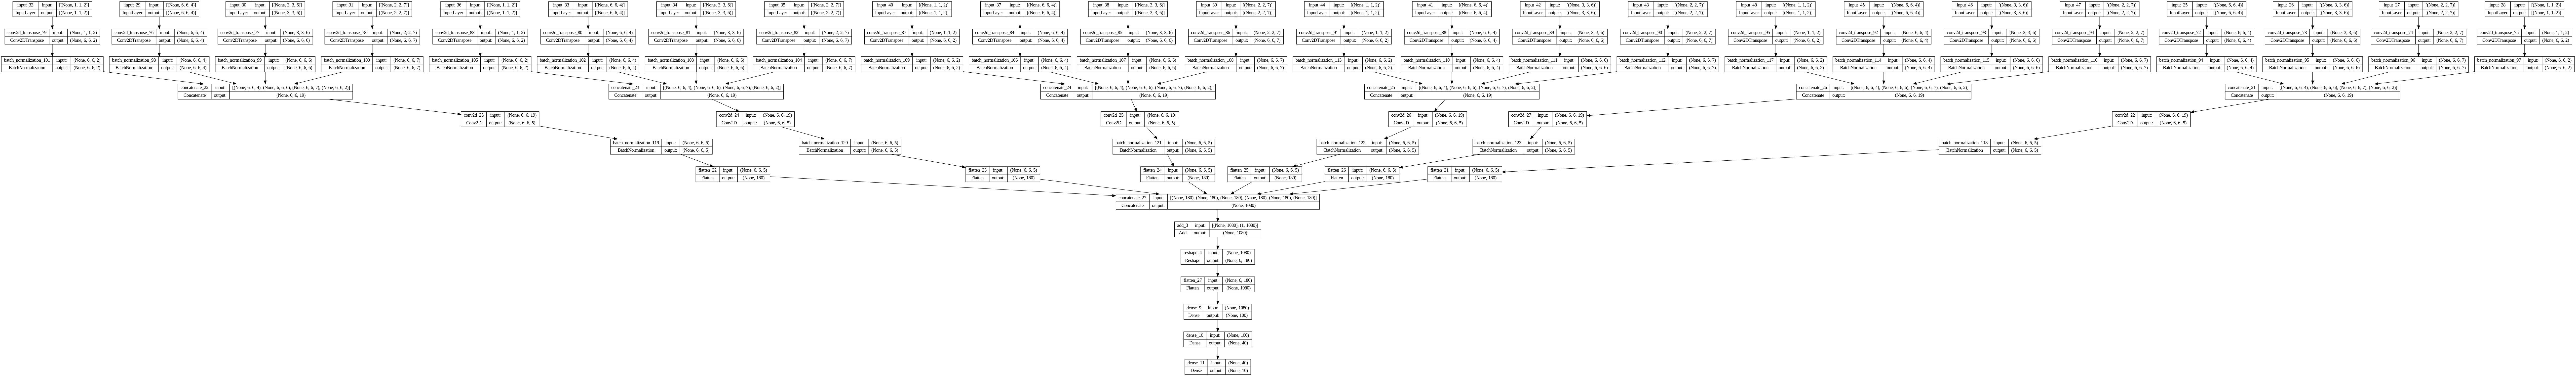

In [ ]:
# CNN classifier (4)
# perform spatial unification
S_1 = spatial_unification(M1_10, M1_20, M1_30, M1_60)
S_2 = spatial_unification(M2_10, M2_20, M2_30, M2_60)
S_3 = spatial_unification(M3_10, M3_20, M3_30, M3_60)
S_4 = spatial_unification(M4_10, M4_20, M4_30, M4_60)
S_5 = spatial_unification(M5_10, M5_20, M5_30, M5_60)
S_6 = spatial_unification(M6_10, M6_20, M6_30, M6_60)

# perform spectral unification
E_1 = spectral_unification(S_1)
E_2 = spectral_unification(S_2)
E_3 = spectral_unification(S_3)
E_4 = spectral_unification(S_4)
E_5 = spectral_unification(S_5)
E_6 = spectral_unification(S_6)

# add positional encoding
W_E = Concatenate(axis=-1)([E_1, E_2, E_3, E_4, E_5, E_6])
W_P = getPositionEncoding()

h_0 = Add()([W_E, W_P])

# reshape input to feed into ff 
h_0 = Reshape((6,180))(h_0)

# feed forward layer + softmax
pred = ff_pred(h_0)

CNN = Model([M1_10, M1_20, M1_30, M1_60, M2_10, M2_20, M2_30, M2_60, M3_10, M3_20, M3_30, M3_60,
              M4_10, M4_20, M4_30, M4_60, M5_10, M5_20, M5_30, M5_60, M6_10, M6_20, M6_30, M6_60],
              [pred])


CNN.summary()
CNN.output_shape
plot_model(CNN, show_shapes=True, to_file='cnn.png')

Epoch 1/1000
30/30 [==============================] - 13s 22ms/step - loss: 2.4342 - accuracy: 0.1187
Epoch 2/1000
30/30 [==============================] - 1s 22ms/step - loss: 2.2689 - accuracy: 0.1800
Epoch 3/1000
30/30 [==============================] - 1s 22ms/step - loss: 2.1670 - accuracy: 0.2427
Epoch 4/1000
30/30 [==============================] - 1s 22ms/step - loss: 2.0852 - accuracy: 0.2827
Epoch 5/1000
30/30 [==============================] - 1s 21ms/step - loss: 2.0169 - accuracy: 0.2987
Epoch 6/1000
30/30 [==============================] - 1s 22ms/step - loss: 1.9651 - accuracy: 0.3400
Epoch 7/1000
30/30 [==============================] - 1s 22ms/step - loss: 1.9182 - accuracy: 0.3573
Epoch 8/1000
30/30 [==============================] - 1s 21ms/step - loss: 1.8786 - accuracy: 0.3667
Epoch 9/1000
30/30 [==============================] - 1s 22ms/step - loss: 1.8467 - accuracy: 0.3747
Epoch 10/1000
30/30 [==============================] - 1s 22ms/step - loss: 1.8265 - accur

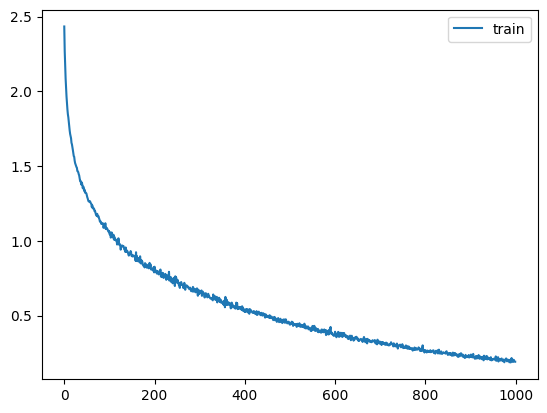

CPU times: user 18min 9s, sys: 20.3 s, total: 18min 29s
Wall time: 14min 54s


In [ ]:
# CNN classifier (4)
%%time
from keras import backend as K
from matplotlib import pyplot
        
opt = keras.optimizers.Adadelta(learning_rate=0.01)
CNN.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

history = CNN.fit(
    x=[
      M1_10_train_X,   M1_20_train_X,  M1_30_train_X,   M1_60_train_X,
      M2_10_train_X,   M2_20_train_X,  M2_30_train_X,   M2_60_train_X,
      M3_10_train_X,   M3_20_train_X,  M3_30_train_X,   M3_60_train_X,
      M4_10_train_X,   M4_20_train_X,  M4_30_train_X,   M4_60_train_X,
      M5_10_train_X,   M5_20_train_X,  M5_30_train_X,   M5_60_train_X,
      M6_10_train_X,   M6_20_train_X,  M6_30_train_X,   M6_60_train_X,
       ],
    y=Crop_train_y,
    epochs=1000,
    batch_size=25,
)

pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

# save model
CNN.save(os.path.join(Modpath, 'cnn_s2'))

#20/20 [==============================] - 1s 27ms/step - loss: 0.2109 - accuracy: 0.9540

In [ ]:
# load model
CNN = keras.models.load_model(os.path.join(Modpath, 'cnn_s1'))

In [ ]:
# predictions
CNN_predict_arr = CNN.predict(
      x=[
      M1_10_test_X,   M1_20_test_X,  M1_30_test_X,   M1_60_test_X,
      M2_10_test_X,   M2_20_test_X,  M2_30_test_X,   M2_60_test_X,
      M3_10_test_X,   M3_20_test_X,  M3_30_test_X,   M3_60_test_X,
      M4_10_test_X,   M4_20_test_X,  M4_30_test_X,   M4_60_test_X,
      M5_10_test_X,   M5_20_test_X,  M5_30_test_X,   M5_60_test_X,
      M6_10_test_X,   M6_20_test_X,  M6_30_test_X,   M6_60_test_X,
       ]
  ) 
CNN_predict = np.argmax(CNN_predict_arr, axis=1)

40/40 [==============================] - 1s 9ms/step


In [ ]:
# metrics are used to find accuracy or error
from sklearn import metrics  
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(Crop_test_y.flatten(), CNN_predict))

# using metrics module for cohen Kappa calculation
print("KAPPA SCORE OF THE MODEL: ", metrics.cohen_kappa_score(Crop_test_y.flatten(), CNN_predict))

ACCURACY OF THE MODEL:  0.8232
KAPPA SCORE OF THE MODEL:  0.8035555555555555


Class Accuracy:  [0.816 0.936 0.712 0.92  0.784 0.928 0.64  0.896 0.808 0.792]
Overall Accuracy:  0.8232
Average Accuracy:  0.8232000000000002


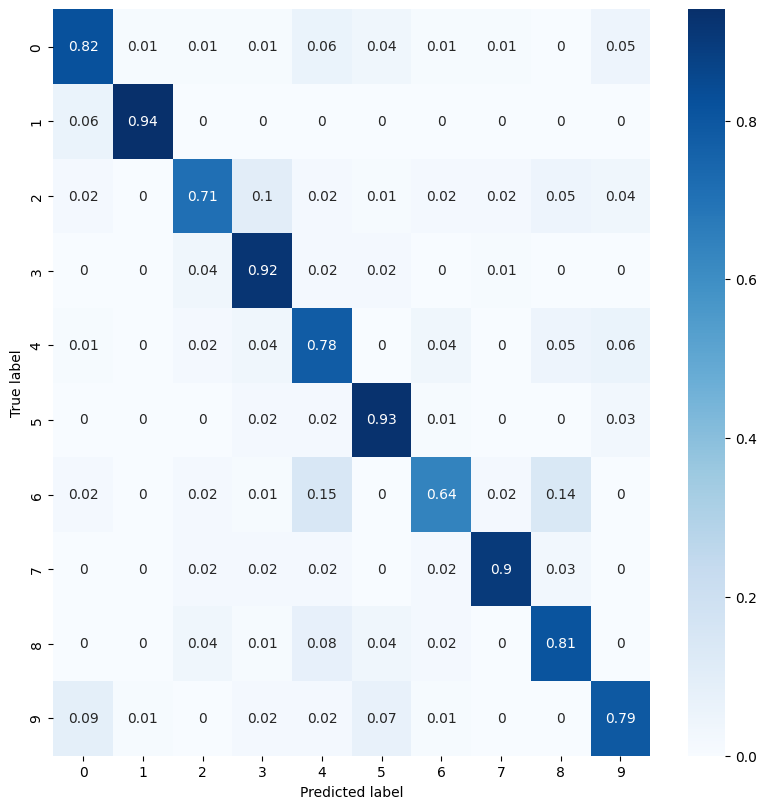

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_true = Crop_test_y.flatten()
classes=[0,1,2,3,4,5,6,7,8,9]

con_mat = tf.math.confusion_matrix(labels=y_true, predictions=CNN_predict).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_norm2 = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=4)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(8, 8))

# Accuracy
DI = con_mat_norm2.diagonal()
OA = (np.sum(con_mat.diagonal())/len(y_true))
AA = (np.sum(DI)/10)
print("Class Accuracy: ", DI)
print("Overall Accuracy: ", OA)
print("Average Accuracy: ", AA)

# heatmap
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 6, 6, 4)]    0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 3, 3, 6)]    0           []                               
                                                                                                  
 input_27 (InputLayer)          [(None, 2, 2, 7)]    0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, 1, 1, 2)]    0           []                               
                                                                                            

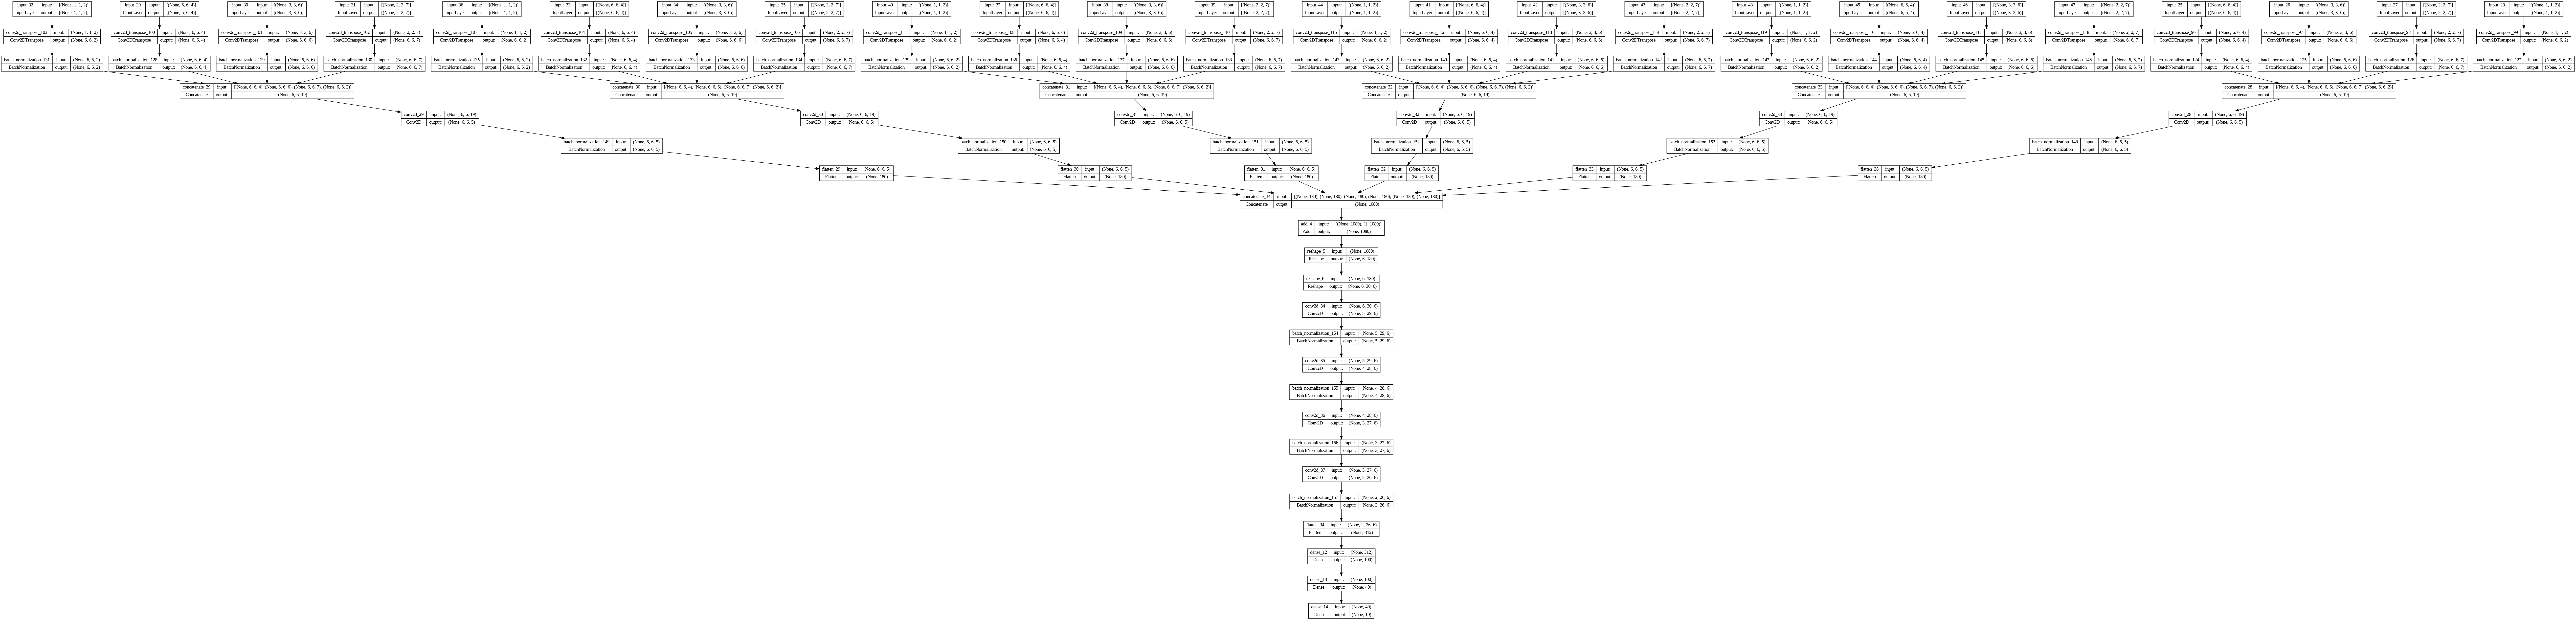

In [ ]:
# CNN-Multitemporal (5)
def cnn_temporal(inputs):
  x = Conv2D(6, (2,2), padding='valid', activation='relu')(inputs)
  x = BatchNormalization()(x)
  x = Conv2D(6, (2,2), padding='valid', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(6, (2,2), padding='valid', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(6, (2,2), padding='valid', activation='relu')(x)
  x = BatchNormalization()(x)
  return x

# perform spatial unification
S_1 = spatial_unification(M1_10, M1_20, M1_30, M1_60)
S_2 = spatial_unification(M2_10, M2_20, M2_30, M2_60)
S_3 = spatial_unification(M3_10, M3_20, M3_30, M3_60)
S_4 = spatial_unification(M4_10, M4_20, M4_30, M4_60)
S_5 = spatial_unification(M5_10, M5_20, M5_30, M5_60)
S_6 = spatial_unification(M6_10, M6_20, M6_30, M6_60)

# perform spectral unification
E_1 = spectral_unification(S_1)
E_2 = spectral_unification(S_2)
E_3 = spectral_unification(S_3)
E_4 = spectral_unification(S_4)
E_5 = spectral_unification(S_5)
E_6 = spectral_unification(S_6)

# add positional encoding
W_E = Concatenate(axis=-1)([E_1, E_2, E_3, E_4, E_5, E_6])
W_P = getPositionEncoding()

h_0 = Add()([W_E, W_P])
# reshape input to feed into CNN temporal
h_0 = Reshape((6,180))(h_0)
h_0 = Reshape((6,30,6))(h_0)

# cnn temporal
h_l = cnn_temporal(h_0)

# Might have to flatten here look at tom

# feed forward layer + softmax
pred = ff_pred(h_l)

CNN_MT = Model([M1_10, M1_20, M1_30, M1_60, M2_10, M2_20, M2_30, M2_60, M3_10, M3_20, M3_30, M3_60,
              M4_10, M4_20, M4_30, M4_60, M5_10, M5_20, M5_30, M5_60, M6_10, M6_20, M6_30, M6_60],
              [pred])


CNN_MT.summary()
CNN_MT.output_shape
plot_model(CNN_MT, show_shapes=True, to_file='cnn-temporal.png')

Epoch 1/1000
30/30 [==============================] - 17s 28ms/step - loss: 2.4519 - accuracy: 0.1053
Epoch 2/1000
30/30 [==============================] - 1s 36ms/step - loss: 2.3476 - accuracy: 0.1213
Epoch 3/1000
30/30 [==============================] - 1s 49ms/step - loss: 2.2742 - accuracy: 0.1213
Epoch 4/1000
30/30 [==============================] - 1s 47ms/step - loss: 2.2086 - accuracy: 0.1467
Epoch 5/1000
30/30 [==============================] - 1s 45ms/step - loss: 2.1514 - accuracy: 0.1587
Epoch 6/1000
30/30 [==============================] - 1s 27ms/step - loss: 2.0847 - accuracy: 0.2000
Epoch 7/1000
30/30 [==============================] - 1s 28ms/step - loss: 2.0462 - accuracy: 0.2147
Epoch 8/1000
30/30 [==============================] - 1s 28ms/step - loss: 1.9911 - accuracy: 0.2387
Epoch 9/1000
30/30 [==============================] - 1s 26ms/step - loss: 1.9522 - accuracy: 0.2720
Epoch 10/1000
30/30 [==============================] - 1s 36ms/step - loss: 1.9131 - accur

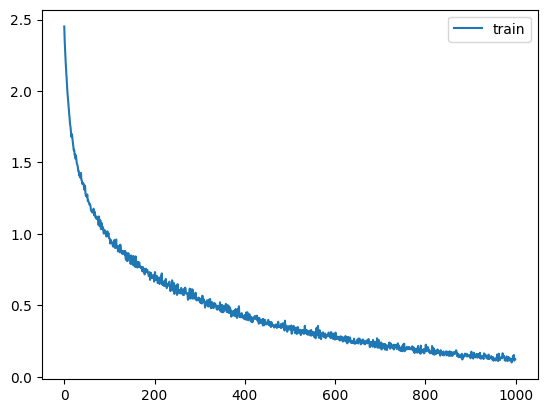

CPU times: user 21min 50s, sys: 19.7 s, total: 22min 10s
Wall time: 18min 58s


In [ ]:
# CNN-Multitemporal (5)
%%time
from keras import backend as K
from matplotlib import pyplot
        
opt = keras.optimizers.Adadelta(learning_rate=0.01)
CNN_MT.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

history = CNN_MT.fit(
    x=[
      M1_10_train_X,   M1_20_train_X,  M1_30_train_X,   M1_60_train_X,
      M2_10_train_X,   M2_20_train_X,  M2_30_train_X,   M2_60_train_X,
      M3_10_train_X,   M3_20_train_X,  M3_30_train_X,   M3_60_train_X,
      M4_10_train_X,   M4_20_train_X,  M4_30_train_X,   M4_60_train_X,
      M5_10_train_X,   M5_20_train_X,  M5_30_train_X,   M5_60_train_X,
      M6_10_train_X,   M6_20_train_X,  M6_30_train_X,   M6_60_train_X,
       ],
    y=Crop_train_y,
    epochs=1000,
    batch_size=25,
)

pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

# save model
CNN_MT.save(os.path.join(Modpath, 'cnn_mt_s2'))

#20/20 [==============================] - 1s 33ms/step - loss: 0.1110 - accuracy: 0.9780

In [ ]:
# load model
CNN_MT = keras.models.load_model(os.path.join(Modpath, 'cnn_mt_s1'))

In [ ]:
# predictions
CNN_MT_predict_arr = CNN_MT.predict(
      x=[
      M1_10_test_X,   M1_20_test_X,  M1_30_test_X,   M1_60_test_X,
      M2_10_test_X,   M2_20_test_X,  M2_30_test_X,   M2_60_test_X,
      M3_10_test_X,   M3_20_test_X,  M3_30_test_X,   M3_60_test_X,
      M4_10_test_X,   M4_20_test_X,  M4_30_test_X,   M4_60_test_X,
      M5_10_test_X,   M5_20_test_X,  M5_30_test_X,   M5_60_test_X,
      M6_10_test_X,   M6_20_test_X,  M6_30_test_X,   M6_60_test_X,
       ]
  ) 
CNN_MT_predict = np.argmax(CNN_MT_predict_arr, axis=1)

40/40 [==============================] - 2s 14ms/step


In [ ]:
# metrics are used to find accuracy or error
from sklearn import metrics  
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(Crop_test_y.flatten(), CNN_MT_predict))

# using metrics module for cohen Kappa calculation
print("KAPPA SCORE OF THE MODEL: ", metrics.cohen_kappa_score(Crop_test_y.flatten(), CNN_MT_predict))

ACCURACY OF THE MODEL:  0.7864
KAPPA SCORE OF THE MODEL:  0.7626666666666666


Class Accuracy:  [0.72  0.912 0.744 0.848 0.744 0.904 0.656 0.848 0.736 0.752]
Overall Accuracy:  0.7864
Average Accuracy:  0.7864


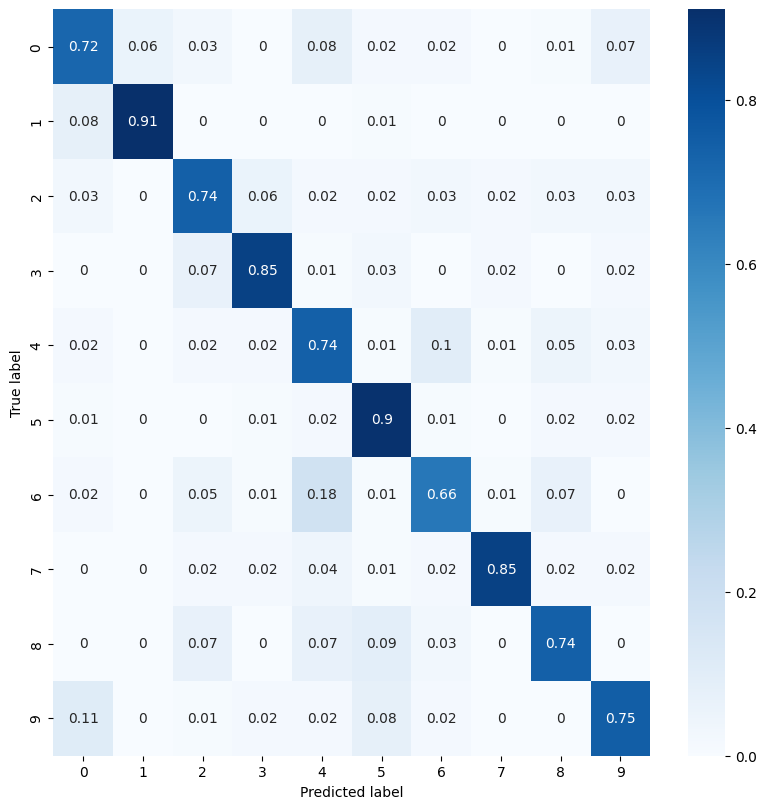

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_true = Crop_test_y.flatten()
classes=[0,1,2,3,4,5,6,7,8,9]

con_mat = tf.math.confusion_matrix(labels=y_true, predictions=CNN_MT_predict).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_norm2 = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=4)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(8, 8))

# Accuracy
DI = con_mat_norm2.diagonal()
OA = (np.sum(con_mat.diagonal())/len(y_true))
AA = (np.sum(DI)/10)
print("Class Accuracy: ", DI)
print("Overall Accuracy: ", OA)
print("Average Accuracy: ", AA)

# heatmap
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 6, 6, 4)]    0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 3, 3, 6)]    0           []                               
                                                                                                  
 input_27 (InputLayer)          [(None, 2, 2, 7)]    0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, 1, 1, 2)]    0           []                               
                                                                                            

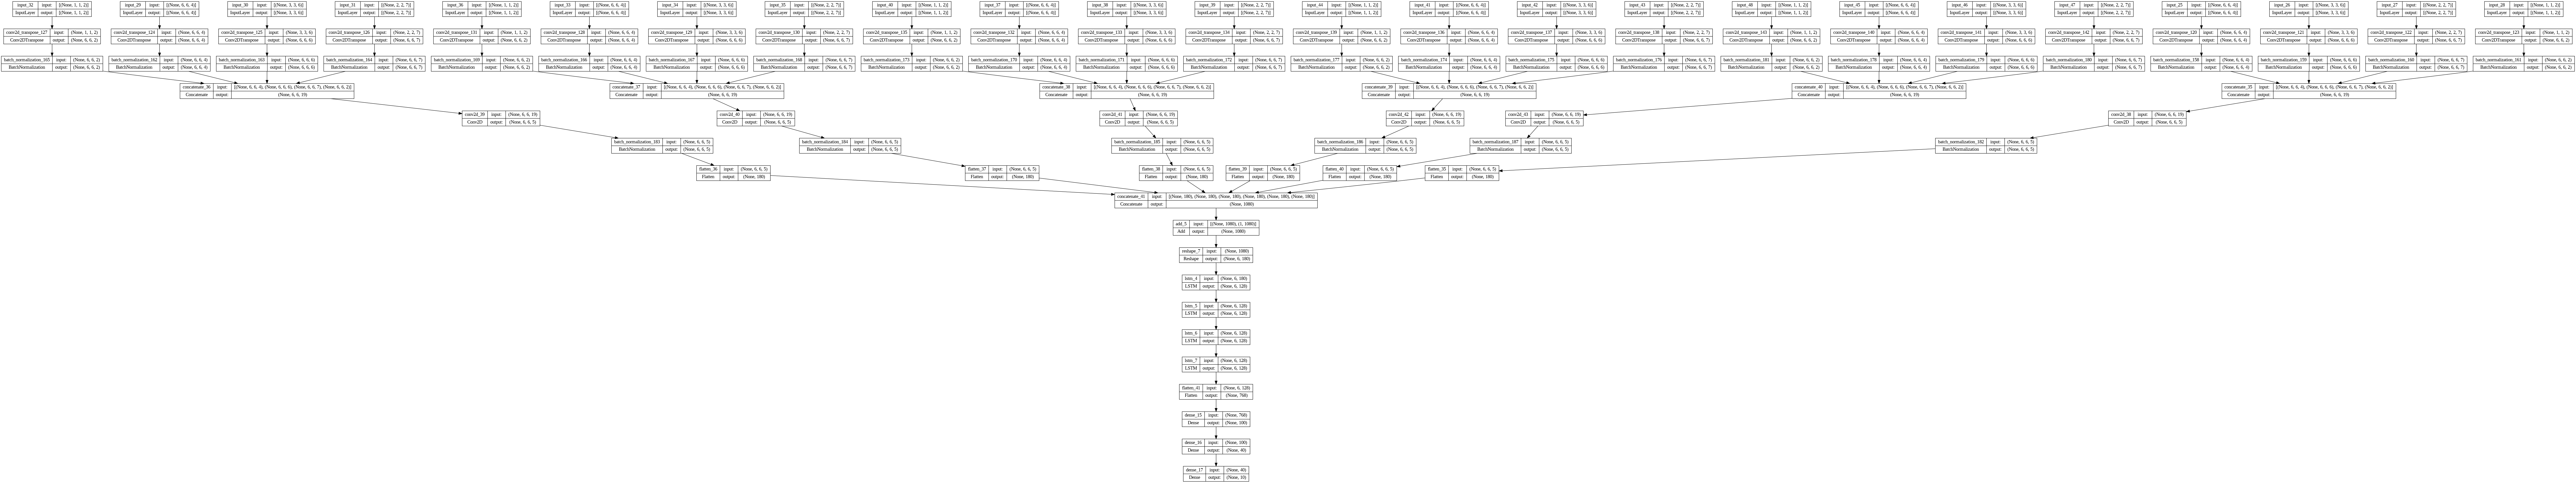

In [ ]:
# CNN-LSTM (6)
from keras.layers import LSTM

def cnn_lstm(inputs):
  b1 = LSTM(128, return_sequences=True)(inputs)
  b2 = LSTM(128, return_sequences=True)(b1)
  b3 = LSTM(128, return_sequences=True)(b2)
  b4 = LSTM(128, return_sequences=True)(b3)
  return b4

# perform spatial unification
S_1 = spatial_unification(M1_10, M1_20, M1_30, M1_60)
S_2 = spatial_unification(M2_10, M2_20, M2_30, M2_60)
S_3 = spatial_unification(M3_10, M3_20, M3_30, M3_60)
S_4 = spatial_unification(M4_10, M4_20, M4_30, M4_60)
S_5 = spatial_unification(M5_10, M5_20, M5_30, M5_60)
S_6 = spatial_unification(M6_10, M6_20, M6_30, M6_60)

# perform spectral unification
E_1 = spectral_unification(S_1)
E_2 = spectral_unification(S_2)
E_3 = spectral_unification(S_3)
E_4 = spectral_unification(S_4)
E_5 = spectral_unification(S_5)
E_6 = spectral_unification(S_6)

# add positional encoding
W_E = Concatenate(axis=-1)([E_1, E_2, E_3, E_4, E_5, E_6])
W_P = getPositionEncoding()

h_0 = Add()([W_E, W_P])

# reshape input to feed into CNN LSTM
h_0 = Reshape((6,180))(h_0)

# cnn temporal
h_l = cnn_lstm(h_0)

# Might have to flatten here look at tom

# feed forward layer + softmax
pred = ff_pred(h_l)

CNN_LSTM = Model([M1_10, M1_20, M1_30, M1_60, M2_10, M2_20, M2_30, M2_60, M3_10, M3_20, M3_30, M3_60,
              M4_10, M4_20, M4_30, M4_60, M5_10, M5_20, M5_30, M5_60, M6_10, M6_20, M6_30, M6_60],
              [pred])


CNN_LSTM.summary()
CNN_LSTM.output_shape
plot_model(CNN_LSTM, show_shapes=True, to_file='cnn-lstm.png')

Epoch 1/1000
30/30 [==============================] - 23s 97ms/step - loss: 2.3027 - accuracy: 0.0413
Epoch 2/1000
30/30 [==============================] - 4s 119ms/step - loss: 2.3023 - accuracy: 0.0653
Epoch 3/1000
30/30 [==============================] - 2s 70ms/step - loss: 2.3020 - accuracy: 0.0973
Epoch 4/1000
30/30 [==============================] - 2s 69ms/step - loss: 2.3016 - accuracy: 0.1000
Epoch 5/1000
30/30 [==============================] - 2s 70ms/step - loss: 2.3012 - accuracy: 0.1013
Epoch 6/1000
30/30 [==============================] - 2s 70ms/step - loss: 2.3009 - accuracy: 0.1093
Epoch 7/1000
30/30 [==============================] - 3s 94ms/step - loss: 2.3005 - accuracy: 0.1227
Epoch 8/1000
30/30 [==============================] - 4s 118ms/step - loss: 2.3001 - accuracy: 0.1573
Epoch 9/1000
30/30 [==============================] - 2s 68ms/step - loss: 2.2997 - accuracy: 0.1987
Epoch 10/1000
30/30 [==============================] - 2s 69ms/step - loss: 2.2994 - acc

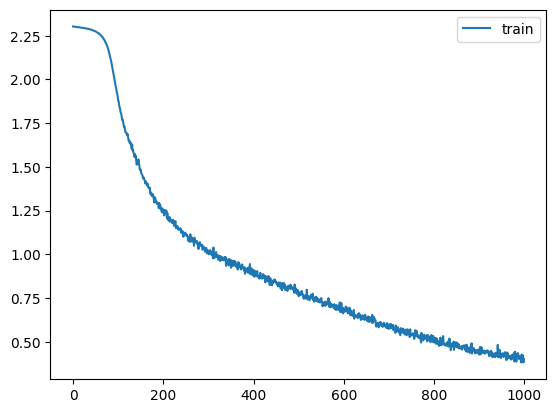

CPU times: user 58min, sys: 2min 16s, total: 1h 16s
Wall time: 46min 19s


In [ ]:
# CNN-LSTM (6)
%%time
from keras import backend as K
from matplotlib import pyplot
        
opt = keras.optimizers.Adadelta(learning_rate=0.01)
CNN_LSTM.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

history = CNN_LSTM.fit(
    x=[
      M1_10_train_X,   M1_20_train_X,  M1_30_train_X,   M1_60_train_X,
      M2_10_train_X,   M2_20_train_X,  M2_30_train_X,   M2_60_train_X,
      M3_10_train_X,   M3_20_train_X,  M3_30_train_X,   M3_60_train_X,
      M4_10_train_X,   M4_20_train_X,  M4_30_train_X,   M4_60_train_X,
      M5_10_train_X,   M5_20_train_X,  M5_30_train_X,   M5_60_train_X,
      M6_10_train_X,   M6_20_train_X,  M6_30_train_X,   M6_60_train_X,
       ],
    y=Crop_train_y,
    epochs=1000,
    batch_size=25,
)

pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

# save model
CNN_LSTM.save(os.path.join(Modpath, 'cnn_lstm_s2'))

#20/20 [==============================] - 2s 83ms/step - loss: 0.6833 - accuracy: 0.7320



In [ ]:
# load model
CNN_LSTM = keras.models.load_model(os.path.join(Modpath, 'cnn_lstm_s1'))

In [ ]:
# predictions
CNN_LSTM_predict_arr = CNN_LSTM.predict(
      x=[
      M1_10_test_X,   M1_20_test_X,  M1_30_test_X,   M1_60_test_X,
      M2_10_test_X,   M2_20_test_X,  M2_30_test_X,   M2_60_test_X,
      M3_10_test_X,   M3_20_test_X,  M3_30_test_X,   M3_60_test_X,
      M4_10_test_X,   M4_20_test_X,  M4_30_test_X,   M4_60_test_X,
      M5_10_test_X,   M5_20_test_X,  M5_30_test_X,   M5_60_test_X,
      M6_10_test_X,   M6_20_test_X,  M6_30_test_X,   M6_60_test_X,
       ]
  ) 
CNN_LSTM_predict = np.argmax(CNN_LSTM_predict_arr, axis=1)

47/47 [==============================] - 1s 31ms/step


In [ ]:
# metrics are used to find accuracy or error
from sklearn import metrics  
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(Crop_test_y.flatten(), CNN_LSTM_predict))

# using metrics module for cohen Kappa calculation
print("KAPPA SCORE OF THE MODEL: ", metrics.cohen_kappa_score(Crop_test_y.flatten(), CNN_LSTM_predict))

ACCURACY OF THE MODEL:  0.6506666666666666
KAPPA SCORE OF THE MODEL:  0.611851851851852


Class Accuracy:  [0.5533 0.9    0.56   0.7    0.36   0.7467 0.6467 0.88   0.5933 0.5667]
Overall Accuracy:  0.6506666666666666
Average Accuracy:  0.6506700000000001


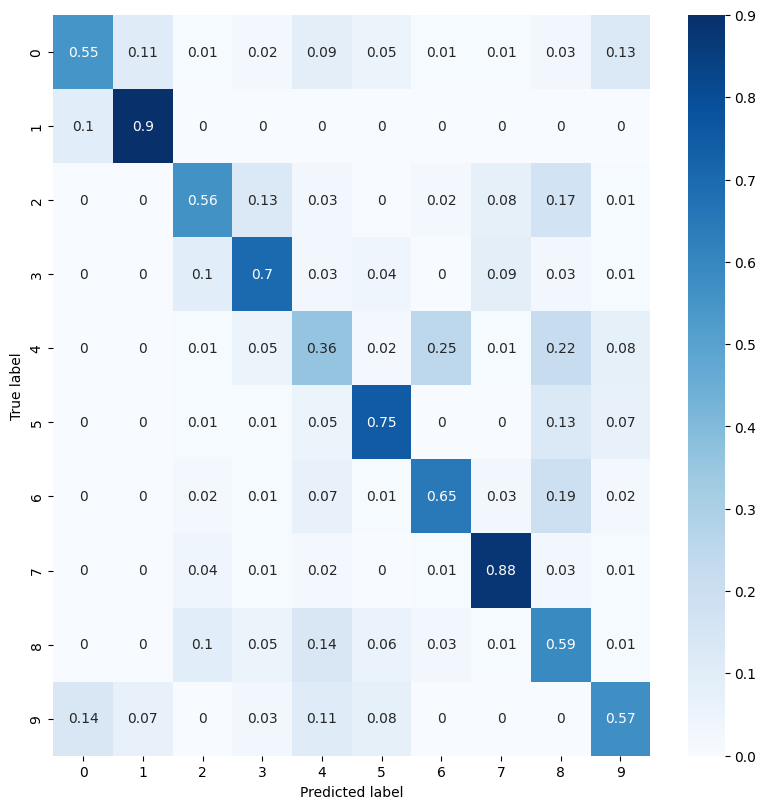

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_true = Crop_test_y.flatten()
classes=[0,1,2,3,4,5,6,7,8,9]

con_mat = tf.math.confusion_matrix(labels=y_true, predictions=CNN_LSTM_predict).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_norm2 = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=4)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(8, 8))

# overall accuracy = (true_positives + true_negatives) / all_samples
DI = con_mat_norm2.diagonal()
OA = (np.sum(con_mat.diagonal())/len(y_true))
AA = (np.sum(DI)/10)
print("Class Accuracy: ", DI)
print("Overall Accuracy: ", OA)
print("Average Accuracy: ", AA)

# heatmap
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()